<a href="https://colab.research.google.com/github/nnn144/Research/blob/master/ced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow

from tensorflow.keras import backend as K

from tensorflow.keras.layers import Input, Dense, Flatten, Lambda, Reshape, Dropout
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, UpSampling2D, Softmax
from tensorflow.keras.layers import BatchNormalization, Activation, ReLU, LeakyReLU
from tensorflow.keras.models import Model

class Attention(tensorflow.keras.layers.Layer):
    def __init__(self, filters):
        super(Attention, self).__init__()
        
        self.query_conv = Conv2D(filters, kernel_size=1, padding='same')
        self.key_conv = Conv2D(filters, kernel_size=1, padding='same')
        self.value_conv = Conv2D(filters, kernel_size=1, padding='same')
        
        self.gamma = K.zeros(shape=(1,))
    
    def call(self, x):
        # get the size
        batchsize, width, height, c = x.shape
        
        # original
        q = self.query_conv(x)
        k = self.key_conv(x)
        v = self.value_conv(x)
        
        # reshape
        qt = K.reshape(q, [-1, width*height, c])
        kt = K.reshape(k, [-1, width*height, c])
        vt = K.reshape(v, [-1, width*height, c])
        
        s = K.batch_dot(K.permute_dimensions(qt, [0, 2, 1]), kt)
        scores = K.batch_dot(vt, K.softmax(s))
        scores = K.reshape(scores, [-1, width, height, c])
        
        return x + self.gamma * scores


class Enc_block(tensorflow.keras.layers.Layer):
    def __init__(self, filters, kernel_size, strides, momentum, beta, downsampling=False, num=1):
        super(Enc_block, self).__init__()
        
        # parameters
        self.filters = filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.momentum = momentum
        self.beta = beta
        
        # number of blocks
        self.num = num
        self.layer_list = []
        
        # for the first conv2d-BN-LeakyReLU block, need to check if downsampling is needed
        # if downsampling, first conv2d layer use (2, 2) for the strides
        if downsampling:
            self.layer_list.append(Conv2D(filters=filters, kernel_size=kernel_size,
                                              strides=(2, 2), padding='same'))
        else:
            self.layer_list.append(Conv2D(filters=filters, kernel_size=kernel_size,
                                              strides=strides, padding='same'))
        self.layer_list.append(BatchNormalization(momentum=momentum))
        self.layer_list.append(LeakyReLU(beta))
        
        # rest of the part will be the same
        for i in range(self.num-1):
            self.layer_list.append(Conv2D(filters=filters, kernel_size=kernel_size,
                                          strides=strides, padding='same'))
            self.layer_list.append(BatchNormalization(momentum=momentum))
            self.layer_list.append(LeakyReLU(beta))
    
    def call(self, x):
        for layer in self.layer_list:
            x = layer(x)
        return x

class Encoder(tensorflow.keras.Model):
    def __init__(self, img_shape, filters, kernel_size, strides,
                       momentum=0.8, beta=0.3, num=1, attention=False, rate=0.2):
        super(Encoder, self).__init__()
        
        self.attention = attention
        self.rate = rate
        
        self.eb1 = Enc_block(filters, kernel_size[0], strides, momentum, beta, False, num)
        self.eb2 = Enc_block(filters*2, kernel_size[0], strides, momentum, beta, True, num)
        self.eb3 = Enc_block(filters*4, kernel_size[0], strides, momentum, beta, True, num)
        self.eb4 = Enc_block(filters*8, kernel_size[1], strides, momentum, beta, True, num)
        self.eb5 = Enc_block(filters*16, kernel_size[1], strides, momentum, beta, True, num)
        self.eb6 = Enc_block(filters*32, kernel_size[1], strides, momentum, beta, True, num)
        
        if self.attention:
            self.sa1 = Attention(filters*8)
            self.sa2 = Attention(filters*16)
    
    def call(self, x):
        e1 = self.eb1(x)
        e2 = self.eb2(e1)
        e3 = self.eb3(e2)
        e4 = self.eb4(e3)
        if self.attention:
            e4 = self.sa1(e4)
        e5 = self.eb5(e4)
        if self.attention:
            e5 = self.sa2(e5)
        e6 = self.eb6(e5)
        
        e_out = Flatten()(e6)
        e_out = Dropout(self.rate)(e_out)
        e_out = Reshape((1, 1, 2048))(e_out)
        
        return e_out

class Dec_block(tensorflow.keras.layers.Layer):
    def __init__(self, filters, kernel_size, strides, momentum, beta, upsampling=False, num=1):
        super(Dec_block, self).__init__()
        
        # parameters
        self.filters = filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.momentum = momentum
        self.beta = beta
        
        # number of blocks
        self.num = num
        self.layer_list = []
        
        # for the first conv2d-BN-LeakyReLU block, need to check if downsampling is needed
        # if downsampling, first conv2d layer use (2, 2) for the strides
        if upsampling:
            self.layer_list.append(UpSampling2D(size=(2, 2)))
        else:
            self.layer_list.append(Conv2DTranspose(filters=filters, kernel_size=kernel_size,
                                                                                 strides=strides, padding='same'))
        self.layer_list.append(BatchNormalization(momentum=momentum))
        self.layer_list.append(LeakyReLU(beta))
        
        # rest of the part will be the same
        for i in range(self.num-1):
            self.layer_list.append(Conv2D(filters=filters, kernel_size=kernel_size,
                                          strides=strides, padding='same'))
            self.layer_list.append(BatchNormalization(momentum=momentum))
            self.layer_list.append(LeakyReLU(beta))
    
    def call(self, x):
        for layer in self.layer_list:
            x = layer(x)
        return x

class Encoder(tensorflow.keras.Model):
    def __init__(self, img_shape, filters, kernel_size, strides,
                       momentum=0.8, beta=0.3, num=1, attention=False, rate=0.2):
        super(Encoder, self).__init__()
        
        self.attention = attention
        self.rate = rate
        
        self.eb1 = Enc_block(filters, kernel_size[0], strides, momentum, beta, False, num)
        self.eb2 = Enc_block(filters*2, kernel_size[0], strides, momentum, beta, True, num)
        self.eb3 = Enc_block(filters*4, kernel_size[0], strides, momentum, beta, True, num)
        self.eb4 = Enc_block(filters*8, kernel_size[1], strides, momentum, beta, True, num)
        self.eb5 = Enc_block(filters*16, kernel_size[1], strides, momentum, beta, True, num)
        self.eb6 = Enc_block(filters*32, kernel_size[1], strides, momentum, beta, True, num)
        
        if self.attention:
            self.sa1 = Attention(filters*8)
            self.sa2 = Attention(filters*16)
    
    def call(self, x):
        e1 = self.eb1(x)
        e2 = self.eb2(e1)
        e3 = self.eb3(e2)
        e4 = self.eb4(e3)
        if self.attention:
            e4 = self.sa1(e4)
        e5 = self.eb5(e4)
        if self.attention:
            e5 = self.sa2(e5)
        e6 = self.eb6(e5)
        
        e_out = Flatten()(e6)
        e_out = Dropout(self.rate)(e_out)
        e_out = Reshape((1, 1, 2048))(e_out)
        
        return e_out

def build_decoder(input_shape, kernels, base, flag, attention=False):
    
    z_vec = Input(shape=input_shape)
    
    if flag == 0:
        d1 = UpSampling2D(size=(2, 2))(z_vec)
        d1 = Conv2D(filters=base*32, kernel_size=kernels, strides=(1, 1), padding='same')(d1)
    else:
        d1 = Conv2DTranspose(filters=base*32, kernel_size=kernels, strides=(2, 2), padding='same')(z_vec)
    d1 = Conv2D(filters=base*32, kernel_size=kernels, strides=(1, 1), padding='same')(d1)
    d1 = BatchNormalization(momentum=0.8)(d1)
    d1 = LeakyReLU(0.3)(d1)
    d1 = Conv2D(filters=base*32, kernel_size=kernels, strides=(1, 1), padding='same')(d1)
    d1 = BatchNormalization(momentum=0.8)(d1)
    d1 = LeakyReLU(0.3)(d1)
    d1 = Conv2D(filters=base*32, kernel_size=kernels, strides=(1, 1), padding='same')(d1)
    d1 = BatchNormalization(momentum=0.8)(d1)
    d1 = LeakyReLU(0.3)(d1)
    
    if flag == 0:
        d2 = UpSampling2D()(d1)
        d2 = Conv2D(filters=base*16, kernel_size=kernels, strides=(1, 1), padding='same')(d2)
    else:
        d2 = Conv2DTranspose(filters=base*16, kernel_size=kernels, strides=(2, 2), padding='same')(d1)
    d2 = BatchNormalization(momentum=0.8)(d2)
    d2 = LeakyReLU(0.3)(d2)
    d2 = Conv2D(filters=base*16, kernel_size=kernels, strides=(1, 1), padding='same')(d2)
    d2 = BatchNormalization(momentum=0.8)(d2)
    d2 = LeakyReLU(0.3)(d2)
    d2 = Conv2D(filters=base*16, kernel_size=kernels, strides=(1, 1), padding='same')(d2)
    d2 = BatchNormalization(momentum=0.8)(d2)
    d2 = LeakyReLU(0.3)(d2)

    if flag == 0:
        d3 = UpSampling2D()(d2)
        d3 = Conv2D(filters=base*8, kernel_size=kernels, strides=(1, 1), padding='same')(d3)
    else:
        d3 = Conv2DTranspose(filters=base*8, kernel_size=kernels, strides=(2, 2), padding='same')(d2)
    d3 = BatchNormalization(momentum=0.8)(d3)
    d3 = LeakyReLU(0.3)(d3)
    d3 = Conv2D(filters=base*8, kernel_size=kernels, strides=(1, 1), padding='same')(d3)
    d3 = BatchNormalization(momentum=0.8)(d3)
    d3 = LeakyReLU(0.3)(d3)
    d3 = Conv2D(filters=base*8, kernel_size=kernels, strides=(1, 1), padding='same')(d3)
    d3 = BatchNormalization(momentum=0.8)(d3)
    d3 = LeakyReLU(0.3)(d3)

    if flag == 0:
        d4 = UpSampling2D()(d3)
        d4 = Conv2D(filters=base*4, kernel_size=kernels, strides=(1, 1), padding='same')(d4)
    else:
        d4 = Conv2DTranspose(filters=base*4, kernel_size=kernels, strides=(2, 2), padding='same')(d3)
    d4 = BatchNormalization(momentum=0.8)(d4)
    d4 = LeakyReLU(0.3)(d4)
    d4 = Conv2D(filters=base*4, kernel_size=kernels, strides=(1, 1), padding='same')(d4)
    d4 = BatchNormalization(momentum=0.8)(d4)
    d4 = LeakyReLU(0.3)(d4)
    d4 = Conv2D(filters=base*4, kernel_size=kernels, strides=(1, 1), padding='same')(d4)
    d4 = BatchNormalization(momentum=0.8)(d4)
    d4 = LeakyReLU(0.3)(d4)
    if attention:
        d4 = Attention(base*4)(d4)

    if flag == 0:
        d5 = UpSampling2D()(d4)
        d5 = Conv2D(filters=base*2, kernel_size=kernels, strides=(1, 1), padding='same')(d5)
    else:
        d5 = Conv2DTranspose(filters=base*2, kernel_size=kernels, strides=(2, 2),
                             padding='same', output_padding=(1, 1))(d4)
    d5 = BatchNormalization(momentum=0.8)(d5)
    d5 = LeakyReLU(0.3)(d5)
    d5 = Conv2D(filters=base*2, kernel_size=kernels, strides=(1, 1), padding='same')(d5)
    d5 = BatchNormalization(momentum=0.8)(d5)
    d5 = LeakyReLU(0.3)(d5)
    d5 = Conv2D(filters=base*2, kernel_size=kernels, strides=(1, 1), padding='same')(d5)
    d5 = BatchNormalization(momentum=0.8)(d5)
    d5 = LeakyReLU(0.3)(d5)
    if attention:
        d5 = Attention(base*2)(d5)
    
    if flag == 0:
        d6 = UpSampling2D()(d5)
        d6 = Conv2D(filters=base, kernel_size=kernels, strides=(1, 1), padding='same')(d6)
    else:
        d6 = Conv2DTranspose(filters=base, kernel_size=kernels, strides=(2, 2),
                             padding='same', output_padding=(1, 1))(d5)
    d6 = BatchNormalization(momentum=0.8)(d6)
    d6 = LeakyReLU(0.3)(d6)
    d6 = Conv2D(filters=base, kernel_size=kernels, strides=(1, 1), padding='same')(d6)
    d6 = BatchNormalization(momentum=0.8)(d6)
    d6 = LeakyReLU(0.3)(d6)
    d6 = Conv2D(filters=base, kernel_size=kernels, strides=(1, 1), padding='same')(d6)
    d6 = BatchNormalization(momentum=0.8)(d6)
    d6 = LeakyReLU(0.3)(d6)
    
    d_out = Conv2D(filters=1, kernel_size=kernels, strides=(1, 1), padding='same')(d6)
    d_out = BatchNormalization(momentum=0.8)(d_out)
    d_out = ReLU()(d_out)
    
    d_out = Dropout(0.2)(d_out)
    model = Model(inputs=z_vec, outputs=d_out)
    model.summary()

    return model

def build_ced(img_shape, base=16, flag=0, attention=False):
    """ Create encoder and decoder """
    # encoder = build_encoder(img_shape=img_shape,
                            # kernels=[(5, 5), (3, 3)],
                            # base=base,
                            # attention=attention)
    encoder = Encoder(img_shape, filters=base, kernel_size=[(5, 5), (3, 3)], strides=(1, 1))
    input_img = Input(shape=img_shape)
    encodings = encoder(input_img)
    
    # input shape of decoder is the same as output shape of encoder
    dec_input_shape = encodings.shape[1:]
    #intermediate = build_intermediate(input_shape=dec_input_shape)
    decoder = build_decoder(input_shape=dec_input_shape,
                            kernels=(3, 3),
                            base=base,
                            flag=flag,
                            attention=attention)

    # Build CED (combined model)
    #medium = intermediate(encodings)
    recon_img = decoder(encodings)
    model = Model(inputs=input_img, outputs=recon_img)
    
    return model

def sample_images(model, x_test, y_test, epoch, path, num_samples=5):
    if not os.path.isdir(path):
        os.mkdir(path)
    
    r, c = 2, num_samples
    idx = np.random.choice(len(x_test), size=c, replace=False)
    idx = np.arange(len(x_test))

    recons = model.predict(x_test[idx])
    
    fig, axs = plt.subplots(r, c, figsize=(5*num_samples, 10))
    for j in range(c):
        axs[0,j].imshow(recons[j,:,:,0], cmap='gray')
        axs[0,j].set_title("Recon {}".format(j))
        axs[0,j].axis('off')
        
        axs[1,j].imshow(y_test[idx[j],:,:,0], cmap='gray')
        axs[1,j].set_title("Real {}".format(j))
        axs[1,j].axis('off')
    
    fig.savefig("{}result_iter{:06}.png".format(path, epoch))
    plt.close()
    return


### Compare with/without Attention (MSE, Normalized image)

In [18]:

y_fbp1 = np.load("fbp_test1_noisy.npy")
y_fbp2 = np.load("fbp_validate1_noisy.npy")
y_fbp = np.concatenate((y_fbp1, y_fbp2))
y_fbp = normalization(y_fbp)
y_fbp.shape

(15, 182, 64)

In [45]:
import numpy as np
import cv2
import pandas as pd
from IPython.display import display
from itertools import chain
from math import log10, sqrt
from sklearn.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim
from skimage.transform import iradon

# linear normalization
def normalization(arr):
    arr_norm = np.zeros(arr.shape)
    arr_norm = cv2.normalize(arr, arr_norm, 0, 255, cv2.NORM_MINMAX)
    return arr_norm

y_test = np.load("y_test_all.npy")
#y_test2 = np.load("./data/y_test1.npy")
#y_test = np.concatenate((y_test1, y_test2))
y_test = normalization(y_test)

y_pred1 = np.load("loss_mse.npy")
y_pred1 = normalization(y_pred1)
y_pred2 = np.load("loss_mse_attention.npy")
y_pred2 = normalization(y_pred2)

y_fbp1 = np.load("fbp_test1_noisy.npy")
y_fbp2 = np.load("fbp_validate1_noisy.npy")
y_fbp = np.concatenate((y_fbp1, y_fbp2))
y_fbp = normalization(y_fbp)
theta = np.linspace(0., 180., 64)
fbp = []
for img in y_fbp:
  fbp.append(iradon(img, theta)[27:155, 27:155])
y_fbp = np.asarray(fbp)

text1 = ["image {}".format(i) for i in range(15)]
text2 = ["MSE", "SSIM", "PSNR"]
text3 = ["FBP", "Without Attention", "With Attention"]

temp = [[i]*3 for i in text2]
arr1 = list(chain.from_iterable(temp))

temp = [text3]*3
arr2 = list(chain.from_iterable(temp))

arr = [arr1, arr2]

tup = list(zip(*arr))
indice = pd.MultiIndex.from_tuples(tup, names=["Measurement", "Recon Method"])

data = np.zeros((15, 9))
for k in range(15):
    data[k, 0] = round(mean_squared_error(y_test[k, ...], y_fbp[k, ...]), 2)
    data[k, 1] = round(mean_squared_error(y_test[k, ...], y_pred1[k, ..., 0]), 2)
    data[k, 2] = round(mean_squared_error(y_test[k, ...], y_pred2[k, ..., 0]), 2)

for k in range(15):
    data[k, 3] = ssim(y_test[k, ...], y_fbp[k, ...], data_range=255)
    data[k, 4] = ssim(y_test[k, ...], y_pred1[k, ..., 0], data_range=255)
    data[k, 5] = ssim(y_test[k, ...], y_pred2[k, ..., 0], data_range=255)

for k in range(15):
    temp = mean_squared_error(y_test[k, ...], y_fbp[k, ...])
    data[k, 6] = 20 * log10(255 / sqrt(temp))
    
    temp = mean_squared_error(y_test[k, ...], y_pred1[k, ..., 0])
    data[k, 7] = 20 * log10(255 / sqrt(temp))

    temp = mean_squared_error(y_test[k, ...], y_pred2[k, ..., 0])
    data[k, 8] = 20 * log10(255 / sqrt(temp))

row_mean = np.zeros((1, 9))
row_std = np.zeros((1, 9))
for i in range(9):
    row_mean[:, i] = np.average(data[:, i])
    row_std[:, i] = np.std(data[:, i])
data = np.concatenate((data, row_mean, row_std))
text1 = text1 + ["mean", "std"]
df = pd.DataFrame(data, index=text1, columns=indice)
df.to_csv("table.csv")
display(df.round(2))

Measurement       MSE                    ...              PSNR               
Recon Method      FBP Without Attention  ... Without Attention With Attention
image 0       4711.81           2166.58  ...             14.77          16.63
image 1       3305.68           1908.89  ...             15.32          18.74
image 2          9.10            128.41  ...             27.04          35.22
image 3         46.68           2403.20  ...             14.32          29.09
image 4        295.64           2622.31  ...             13.94          25.13
image 5        557.69            381.30  ...             22.32          28.19
image 6        217.01            221.24  ...             24.68          29.67
image 7         56.82            341.72  ...             22.79          29.41
image 8       3375.41            821.71  ...             18.98          33.47
image 9       4378.38            597.63  ...             20.37          29.70
image 10      1151.54           2075.14  ...             14.96          25.96
image 11       532.84           1598.09  ...             16.09          29.14
image 12       445.80            238.74  ...             24.35          30.47
image 13       689.61            253.24  ...             24.10          25.43
image 14      3195.94           1919.11  ...             15.30          30.04
mean          1531.33           1178.49  ...             19.29          27.75
std           1662.67            901.17  ...              4.43           4.73

[17 rows x 9 columns]

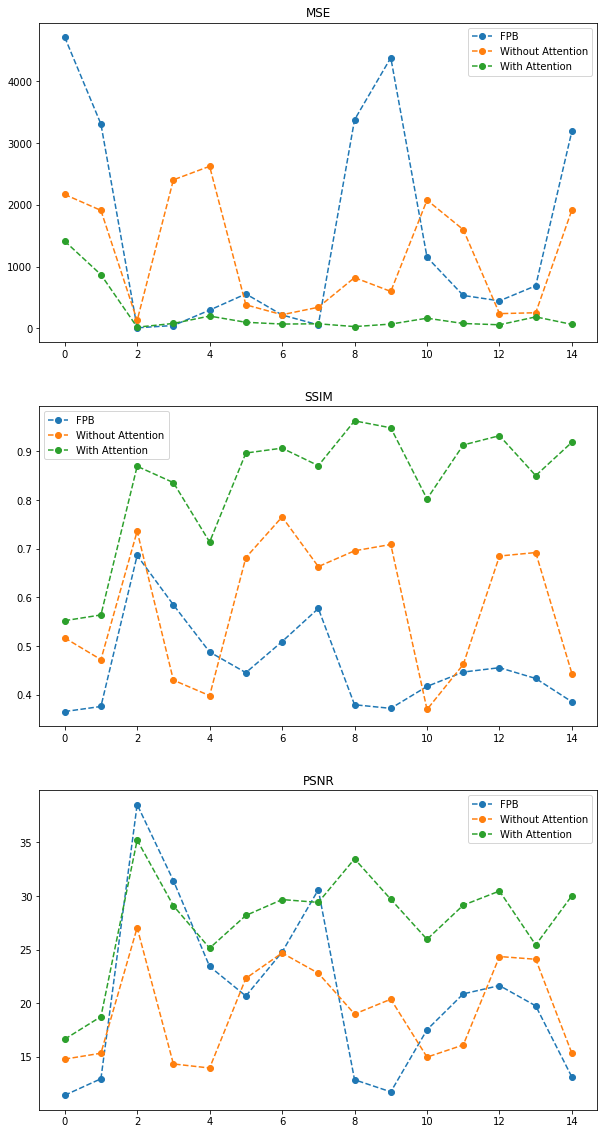

In [51]:
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 20))
labels = ["FPB", "Without Attention", "With Attention"]
for i in range(3):
  ax1.plot(np.arange(15), data[:15, i], '--o', label=labels[i])
ax1.legend()
ax1.set_title("MSE")

for i in range(3):
  ax2.plot(np.arange(15), data[:15, i+3], '--o', label=labels[i])
ax2.legend()
ax2.set_title("SSIM")

for i in range(3):
  ax3.plot(np.arange(15), data[:15, i+6], '--o', label=labels[i])
ax3.legend()
ax3.set_title("PSNR")

fig.savefig("/content/drive/MyDrive/Colab Notebooks/compare.png")
plt.show()

In [50]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
